In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_473532/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


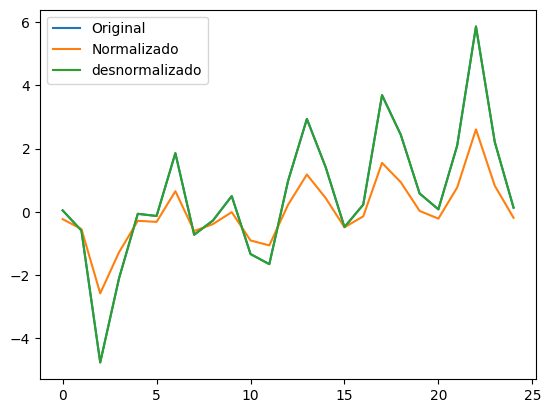

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 4.12 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-02 19:20:21.689789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 19:20:21.689833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 19:20:21.691071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 19:20:21.697969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-02 19:20:22.650276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  34
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  47
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_5,0.920073,0.742170,0.772851,0.939695,0.360040,1.724112,0.812499,0.417904,1.314957,0.600034,1.662255,0.610470,132.043078,267.083012
model_1_0_4,0.918494,0.740640,0.771552,0.938920,0.367151,1.734342,0.817145,0.423278,1.331098,0.605930,1.675335,0.616469,132.003963,267.043897
model_1_0_3,0.916795,0.738852,0.770847,0.937799,0.374805,1.746297,0.819667,0.431047,1.346947,0.612213,1.689413,0.622861,131.962699,267.002633
model_1_0_2,0.913936,0.735493,0.770435,0.935223,0.387683,1.768761,0.821142,0.448899,1.343560,0.622642,1.713101,0.633472,131.895133,266.935067
model_1_0_1,0.899980,0.708601,0.788175,0.916176,0.450548,1.948585,0.757684,0.580893,1.120910,0.671228,1.828733,0.682903,131.594583,266.634517
model_1_0_0,0.898132,0.707043,0.786631,0.914795,0.458872,1.959002,0.763207,0.590457,1.134296,0.677401,1.844045,0.689183,131.557968,266.597902


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.944163,0.761850,0.775518,0.952594,0.251523,1.592512,0.802960,0.203837,1.102308,0.501521,1.462650,0.510244,132.760440,267.800374
model_1_1_8,0.941919,0.758658,0.777029,0.950552,0.261629,1.613855,0.797553,0.212615,1.102411,0.511497,1.481239,0.520393,132.681653,267.721586
model_1_1_6,0.939314,0.757534,0.778578,0.949841,0.273366,1.621373,0.792012,0.215674,1.137479,0.522844,1.502827,0.531938,132.593888,267.633822
model_1_1_7,0.940466,0.757116,0.778907,0.949039,0.268176,1.624164,0.790838,0.219122,1.109628,0.517857,1.493280,0.526864,132.632224,267.672158
model_1_1_5,0.938188,0.756593,0.778186,0.949174,0.278436,1.627666,0.793414,0.218542,1.146929,0.527671,1.512153,0.536848,132.557132,267.597066
model_1_1_4,0.937098,0.755644,0.778086,0.948311,0.283350,1.634012,0.793773,0.222251,1.155939,0.532306,1.521192,0.541565,132.522144,267.562078
model_1_1_3,0.935820,0.754518,0.777665,0.947222,0.289106,1.641541,0.795278,0.226932,1.166666,0.537686,1.531779,0.547037,132.481925,267.521859
model_1_1_2,0.925399,0.745816,0.775768,0.937624,0.336047,1.699731,0.802064,0.268204,1.244594,0.579696,1.618122,0.589778,132.181008,267.220942
model_1_1_1,0.923895,0.744564,0.775047,0.936374,0.342823,1.708102,0.804643,0.273576,1.256654,0.585510,1.630585,0.595694,132.141085,267.181019
model_1_1_0,0.921687,0.743439,0.773431,0.933141,0.352767,1.715627,0.810423,0.287480,1.301265,0.593942,1.648876,0.604272,132.083895,267.123829


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.952844,0.770606,0.777361,0.945474,0.212419,1.533956,0.796366,0.259504,0.956076,0.460890,1.390722,0.468906,133.098385,268.138318
model_1_2_8,0.951956,0.769774,0.776864,0.943950,0.216421,1.539523,0.798145,0.266759,0.974468,0.465210,1.398082,0.473302,133.061062,268.100996
model_1_2_7,0.950847,0.768749,0.775557,0.942068,0.221415,1.546379,0.802820,0.275717,0.993705,0.470548,1.407269,0.478732,133.015433,268.055367
model_1_2_6,0.949729,0.767764,0.774140,0.940185,0.226450,1.552961,0.807890,0.284678,1.016216,0.475867,1.416530,0.484144,132.970465,268.010399
model_1_2_5,0.949573,0.767169,0.776577,0.941458,0.227154,1.556943,0.799173,0.278619,1.005093,0.476607,1.417825,0.484896,132.964255,268.004189
model_1_2_4,0.947868,0.765559,0.775732,0.937271,0.234834,1.567711,0.802194,0.298547,1.065204,0.484597,1.431952,0.493025,132.897752,267.937685
model_1_2_3,0.946753,0.764587,0.774487,0.935601,0.239857,1.574210,0.806647,0.306492,1.081314,0.489752,1.441191,0.498270,132.855422,267.895356
model_1_2_2,0.945606,0.763673,0.772736,0.933745,0.245024,1.580319,0.812909,0.315327,1.099965,0.494999,1.450695,0.503608,132.812797,267.852731
model_1_2_0,0.945326,0.762837,0.776833,0.935616,0.246286,1.585913,0.798254,0.306422,1.086431,0.496272,1.453017,0.504904,132.802521,267.842455
model_1_2_1,0.944626,0.762819,0.770884,0.931985,0.249439,1.586033,0.819536,0.323705,1.113456,0.499439,1.458816,0.508125,132.777083,267.817017


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 157ms/step


 1/32 [..............................] - ETA: 4s

 3/32 [=>............................] - ETA: 1s

 6/32 [====>.........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 1s 22ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 88ms/step


 1/32 [..............................] - ETA: 2s

 7/32 [=====>........................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.977454,0.810130,0.783263,0.992475,0.101559,1.269660,0.775257,0.041704,0.639513,0.318684,1.186807,0.324226,134.574226,269.614159
model_1_3_8,0.977048,0.809918,0.783107,0.992339,0.103392,1.271082,0.775813,0.042459,0.649195,0.321546,1.190177,0.327138,134.538465,269.578398
model_1_3_7,0.976716,0.809254,0.781254,0.992844,0.104887,1.275517,0.782441,0.039663,0.651813,0.323862,1.192928,0.329495,134.509747,269.549680
model_1_3_6,0.973466,0.803468,0.773139,0.991336,0.119527,1.314209,0.811467,0.048019,0.713332,0.345727,1.219857,0.351740,134.248423,269.288357
model_1_3_5,0.970287,0.798500,0.771830,0.989979,0.133847,1.347433,0.816150,0.055540,0.764250,0.365851,1.246197,0.372214,134.022119,269.062053
model_1_3_4,0.966024,0.798006,0.764309,0.987580,0.153048,1.350731,0.843054,0.068834,0.891540,0.391214,1.281516,0.398018,133.754001,268.793935
model_1_3_3,0.962067,0.785730,0.784733,0.985000,0.170873,1.432822,0.769999,0.083131,0.947033,0.413368,1.314303,0.420558,133.533665,268.573599
model_1_3_2,0.960977,0.783318,0.780905,0.984482,0.175782,1.448952,0.783691,0.086002,0.930144,0.419264,1.323332,0.426556,133.477018,268.516952
model_1_3_1,0.955318,0.774802,0.778210,0.980494,0.201273,1.505900,0.793329,0.108108,0.943590,0.448635,1.370220,0.456438,133.206183,268.246116
model_1_3_0,0.953719,0.771768,0.777937,0.978846,0.208479,1.526190,0.794305,0.117240,0.949440,0.456595,1.383475,0.464537,133.135832,268.175766


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 2s

 6/32 [====>.........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 1s

10/32 [========>.....................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 79ms/step


 1/32 [..............................] - ETA: 2s

 6/32 [====>.........................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 11ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 155ms/step


 1/32 [..............................] - ETA: 3s

 7/32 [=====>........................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 9ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.987491,0.822034,0.791746,0.990423,0.056346,1.190062,0.744912,0.039632,0.473410,0.237373,1.103642,0.241502,135.752489,270.792423
model_1_4_8,0.986997,0.819191,0.799092,0.990312,0.058574,1.209068,0.718636,0.040095,0.472241,0.242020,1.107740,0.246229,135.674943,270.714877
model_1_4_7,0.986706,0.819088,0.798565,0.989979,0.059882,1.209758,0.720523,0.041470,0.479850,0.244708,1.110146,0.248964,135.630763,270.670697
model_1_4_6,0.986548,0.819080,0.798908,0.989630,0.060594,1.209810,0.719295,0.042914,0.483535,0.246159,1.111456,0.250440,135.607118,270.647052
model_1_4_5,0.983715,0.817783,0.793175,0.985771,0.073360,1.218485,0.739803,0.058888,0.526633,0.270850,1.134937,0.275561,135.224764,270.264698
model_1_4_4,0.983410,0.817604,0.792856,0.985523,0.074732,1.219684,0.740941,0.059911,0.532003,0.273371,1.137461,0.278126,135.187697,270.227631
model_1_4_3,0.983128,0.817241,0.792592,0.985320,0.076003,1.222110,0.741887,0.060753,0.534449,0.275687,1.139800,0.280482,135.153960,270.193894
model_1_4_2,0.982410,0.816564,0.791985,0.984824,0.079237,1.226635,0.744059,0.062807,0.543094,0.281491,1.145748,0.286387,135.070617,270.110550
model_1_4_1,0.982145,0.816232,0.790672,0.983923,0.080431,1.228859,0.748754,0.066535,0.557507,0.283604,1.147945,0.288537,135.040700,270.080634
model_1_4_0,0.981773,0.815925,0.790419,0.983600,0.082107,1.230909,0.749660,0.067872,0.563226,0.286543,1.151027,0.291527,134.999465,270.039399


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  11


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 10ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

19/32 [================>.............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 9ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 58ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.991933,0.826844,0.791402,0.990501,0.036341,1.157894,0.746143,0.042114,0.370717,0.190632,1.066845,0.193948,136.629639,271.669573
model_1_5_8,0.991791,0.826780,0.791205,0.990417,0.036978,1.158321,0.746848,0.042487,0.374177,0.192295,1.068016,0.195640,136.594891,271.634825
model_1_5_7,0.991671,0.826718,0.791272,0.990389,0.037518,1.158738,0.746608,0.042612,0.377097,0.193695,1.069010,0.197064,136.565873,271.605807
model_1_5_6,0.991533,0.826698,0.790581,0.990366,0.038140,1.158874,0.749079,0.042712,0.382230,0.195295,1.070155,0.198692,136.532968,271.572902
model_1_5_5,0.991173,0.824084,0.792352,0.989624,0.039764,1.176349,0.742745,0.046003,0.366403,0.199409,1.073141,0.202877,136.449599,271.489532
model_1_5_4,0.991005,0.824004,0.792070,0.989477,0.040518,1.176889,0.743753,0.046654,0.370904,0.201291,1.074529,0.204792,136.412005,271.451939
model_1_5_1,0.988464,0.823676,0.788453,0.987297,0.051965,1.179080,0.756690,0.056319,0.419670,0.227959,1.095585,0.231924,135.914358,270.954292
model_1_5_0,0.988283,0.823500,0.788321,0.987232,0.052779,1.180259,0.757165,0.056607,0.423376,0.229736,1.097081,0.233732,135.883291,270.923224
model_1_5_3,0.990236,0.823229,0.791489,0.988944,0.043981,1.182068,0.745832,0.049018,0.390505,0.209716,1.080898,0.213364,136.248003,271.287937
model_1_5_2,0.990058,0.823109,0.791224,0.988819,0.044785,1.182872,0.746779,0.049571,0.395003,0.211626,1.082378,0.215306,136.211747,271.251681


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_2,0.992813,0.826779,0.792379,0.993202,0.032373,1.158328,0.742648,0.036702,0.373105,0.179924,1.059546,0.183053,136.860883,271.900816
model_1_6_4,0.993678,0.826709,0.794372,0.993956,0.028476,1.158795,0.735521,0.032631,0.357637,0.168748,1.052378,0.171683,137.117393,272.157326
model_1_6_0,0.992190,0.826705,0.792600,0.993181,0.035181,1.158825,0.741859,0.036813,0.364591,0.187565,1.064711,0.190827,136.694518,271.734451
model_1_6_1,0.992316,0.826659,0.792496,0.993277,0.034613,1.159131,0.742230,0.036299,0.361805,0.186045,1.063666,0.189280,136.727074,271.767008
model_1_6_3,0.992924,0.826641,0.792248,0.993307,0.031876,1.159250,0.743116,0.036137,0.371768,0.178539,1.058633,0.181644,136.891793,271.931727
model_1_6_6,0.994685,0.826046,0.795807,0.994739,0.023942,1.163234,0.730385,0.028406,0.352228,0.154731,1.044038,0.157422,137.464281,272.504215
model_1_6_9,0.994913,0.825880,0.795997,0.994912,0.022914,1.164339,0.729709,0.027471,0.346976,0.151374,1.042148,0.154007,137.552001,272.591935
model_1_6_5,0.994603,0.825876,0.795718,0.994662,0.024310,1.164368,0.730706,0.028821,0.356551,0.155916,1.044715,0.158628,137.433758,272.473692
model_1_6_7,0.994764,0.825863,0.795684,0.994820,0.023587,1.164455,0.730826,0.027968,0.352626,0.153581,1.043386,0.156252,137.494108,272.534041
model_1_6_8,0.994833,0.825807,0.795768,0.994856,0.023277,1.164828,0.730527,0.027771,0.350595,0.152566,1.042815,0.155220,137.520621,272.560555


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 72ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.995040,0.825115,0.797206,0.993022,0.022341,1.169459,0.725383,0.020321,0.349440,0.149470,1.041094,0.152070,137.602642,272.642576
model_1_7_1,0.995338,0.825045,0.799088,0.992060,0.021000,1.169925,0.718650,0.023121,0.339972,0.144914,1.038627,0.147434,137.726464,272.766398
model_1_7_2,0.995404,0.824984,0.799208,0.992032,0.020701,1.170331,0.718222,0.023204,0.336911,0.143878,1.038077,0.146381,137.755153,272.795087
model_1_7_6,0.995792,0.824937,0.802201,0.992042,0.018956,1.170646,0.707516,0.023174,0.320476,0.137681,1.034867,0.140075,137.931275,272.971209
model_1_7_5,0.995724,0.824890,0.800819,0.992339,0.019261,1.170963,0.712457,0.022310,0.327220,0.138784,1.035428,0.141197,137.899359,272.939292
model_1_7_8,0.995911,0.824888,0.802670,0.992099,0.018418,1.170973,0.705837,0.023007,0.316235,0.135713,1.033878,0.138073,137.988854,273.028787
model_1_7_9,0.995992,0.824860,0.802773,0.992283,0.018054,1.171159,0.705469,0.022473,0.312030,0.134366,1.033209,0.136702,138.028766,273.068700
model_1_7_7,0.995852,0.824848,0.802449,0.992069,0.018686,1.171245,0.706630,0.023095,0.318309,0.136699,1.034372,0.139076,137.959908,272.999842
model_1_7_3,0.995560,0.824843,0.799805,0.992186,0.019999,1.171273,0.716087,0.022756,0.331778,0.141416,1.036785,0.143876,137.824184,272.864117
model_1_7_4,0.995638,0.824776,0.800035,0.992282,0.019649,1.171720,0.715263,0.022474,0.329010,0.140176,1.036143,0.142614,137.859417,272.899351


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.996447,0.825233,0.803965,0.997932,0.016005,1.168667,0.701206,0.010492,0.277688,0.126511,1.029439,0.128711,138.269713,273.309647
model_1_8_1,0.996526,0.825223,0.804143,0.997996,0.015648,1.168736,0.700567,0.010163,0.278075,0.125091,1.028782,0.127267,138.314859,273.354793
model_1_8_3,0.997076,0.824885,0.804233,0.998775,0.013172,1.170997,0.700248,0.006212,0.276366,0.114769,1.024228,0.116766,138.659321,273.699254
model_1_8_2,0.996941,0.824864,0.803992,0.998661,0.013781,1.171134,0.701110,0.006794,0.281583,0.117392,1.025348,0.119434,138.568948,273.608882
model_1_8_9,0.998025,0.823279,0.805184,0.999338,0.008895,1.181732,0.696845,0.003359,0.221057,0.094311,1.016361,0.095951,139.444624,274.484558
model_1_8_8,0.997997,0.823230,0.805141,0.999353,0.009025,1.182059,0.697001,0.003281,0.224083,0.094998,1.016600,0.096651,139.415583,274.455517
model_1_8_7,0.997632,0.822078,0.805435,0.999318,0.010668,1.189767,0.695949,0.003460,0.243839,0.103285,1.019622,0.105081,139.081057,274.120991
model_1_8_6,0.997582,0.822049,0.805414,0.999310,0.010892,1.189960,0.696023,0.003501,0.247183,0.104362,1.020034,0.106178,139.039541,274.079475
model_1_8_5,0.997217,0.821340,0.803472,0.999106,0.012537,1.194698,0.702971,0.004536,0.282915,0.111969,1.023061,0.113917,138.758117,273.798051
model_1_8_4,0.997153,0.821284,0.803481,0.999064,0.012824,1.195076,0.702937,0.004745,0.287619,0.113243,1.023588,0.115213,138.712879,273.752813


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.998462,0.824280,0.805830,0.993822,0.006927,1.175043,0.694533,0.014120,0.151676,0.083231,1.012742,0.084678,139.944561,274.984495
model_1_9_1,0.998222,0.823584,0.805816,0.993567,0.008011,1.179698,0.694586,0.014703,0.211789,0.089502,1.014735,0.091058,139.653992,274.693926
model_1_9_8,0.998396,0.823482,0.806498,0.993849,0.007224,1.180379,0.692146,0.014058,0.181998,0.084994,1.013288,0.086473,139.860675,274.900609
model_1_9_0,0.998150,0.823426,0.805700,0.993293,0.008332,1.180753,0.695001,0.015328,0.214921,0.091280,1.015326,0.092868,139.575288,274.615222
model_1_9_7,0.998378,0.823408,0.806192,0.993814,0.007304,1.180871,0.693239,0.014140,0.184444,0.085465,1.013435,0.086952,139.838585,274.878518
model_1_9_5,0.998327,0.823363,0.806180,0.993655,0.007538,1.181175,0.693282,0.014502,0.188887,0.086822,1.013865,0.088332,139.775577,274.815511
model_1_9_6,0.998358,0.823360,0.806153,0.993757,0.007396,1.181196,0.693379,0.014269,0.186953,0.085999,1.013604,0.087495,139.813655,274.853589
model_1_9_2,0.998230,0.823294,0.806578,0.993299,0.007973,1.181635,0.691861,0.015316,0.194185,0.089291,1.014665,0.090844,139.663415,274.703349
model_1_9_4,0.998286,0.823279,0.806374,0.993469,0.007721,1.181731,0.692589,0.014928,0.190120,0.087868,1.014202,0.089396,139.727681,274.767615
model_1_9_3,0.998255,0.823262,0.806418,0.993349,0.007861,1.181848,0.692433,0.015201,0.192261,0.088663,1.014460,0.090205,139.691641,274.731575


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_8,0.999121,0.828408,0.811637,0.998426,0.003958,1.147440,0.673765,0.004942,0.134642,0.062914,1.007281,0.064008,141.063933,276.103866
model_1_10_9,0.999134,0.828317,0.811495,0.998491,0.003901,1.148046,0.674270,0.004737,0.131905,0.062461,1.007176,0.063548,141.092826,276.132760
model_1_10_7,0.999048,0.828158,0.811244,0.998460,0.004289,1.149106,0.675168,0.004837,0.140472,0.065489,1.007889,0.066628,140.903508,275.943442
model_1_10_6,0.999043,0.827956,0.811275,0.998453,0.004311,1.150459,0.675058,0.004858,0.141824,0.065657,1.007929,0.066799,140.893231,275.933165
model_1_10_5,0.998865,0.826367,0.809874,0.998671,0.005114,1.161083,0.680069,0.004173,0.123942,0.071515,1.009407,0.072758,140.551413,275.591347
model_1_10_4,0.998841,0.826344,0.809861,0.998631,0.005220,1.161238,0.680117,0.004298,0.125371,0.072249,1.009602,0.073506,140.510521,275.550455
model_1_10_3,0.998684,0.826060,0.808896,0.998491,0.005929,1.163138,0.683567,0.004737,0.131819,0.076998,1.010905,0.078337,140.255926,275.295860
model_1_10_2,0.998647,0.826045,0.808625,0.998414,0.006096,1.163240,0.684539,0.004979,0.135418,0.078075,1.011212,0.079433,140.200353,275.240287
model_1_10_1,0.998620,0.826001,0.808754,0.998380,0.006216,1.163531,0.684077,0.005086,0.131533,0.078845,1.011435,0.080216,140.161102,275.201036
model_1_10_0,0.998538,0.824612,0.806618,0.998128,0.006587,1.172821,0.691716,0.005879,0.139811,0.081161,1.012116,0.082573,140.045286,275.085220


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.999184,0.828342,0.811319,0.998207,0.003675,1.147879,0.674901,0.004750,0.129347,0.060622,1.006760,0.061676,141.212421,276.252355
model_1_11_1,0.999248,0.827968,0.811394,0.998214,0.003387,1.150381,0.674632,0.004730,0.123686,0.058202,1.006231,0.059214,141.375334,276.415268
model_1_11_7,0.999266,0.827922,0.812051,0.997662,0.003305,1.150685,0.672283,0.006193,0.106813,0.057486,1.006079,0.058486,141.424853,276.464787
model_1_11_8,0.999199,0.827901,0.812154,0.996857,0.003607,1.150830,0.671914,0.008325,0.100679,0.060058,1.006635,0.061103,141.249758,276.289692
model_1_11_2,0.999251,0.827895,0.811295,0.998181,0.003376,1.150866,0.674985,0.004818,0.123749,0.058100,1.006209,0.059111,141.382340,276.422274
model_1_11_3,0.999241,0.827895,0.811223,0.997965,0.003418,1.150867,0.675244,0.005388,0.116292,0.058462,1.006287,0.059479,141.357488,276.397421
model_1_11_6,0.999263,0.827866,0.812008,0.997716,0.003320,1.151060,0.672437,0.006048,0.107089,0.057617,1.006106,0.058619,141.415755,276.455689
model_1_11_5,0.999256,0.827865,0.812090,0.997729,0.003350,1.151065,0.672145,0.006014,0.107398,0.057880,1.006162,0.058887,141.397530,276.437463
model_1_11_4,0.999246,0.827830,0.811249,0.997911,0.003395,1.151304,0.675151,0.005531,0.113183,0.058269,1.006245,0.059282,141.370748,276.410682
model_1_11_9,0.999225,0.827340,0.811369,0.996660,0.003493,1.154577,0.674723,0.008844,0.091546,0.059104,1.006425,0.060132,141.313858,276.353792


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  33
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_6,0.999524,0.827628,0.812537,0.999440,0.002146,1.152653,0.670544,0.002785,0.121790,0.046320,1.003947,0.047126,142.288693,277.328626
model_1_12_5,0.999520,0.827584,0.812067,0.999494,0.002161,1.152945,0.672226,0.002517,0.120559,0.046485,1.003975,0.047293,142.274522,277.314455
model_1_12_7,0.999537,0.827489,0.812318,0.999451,0.002084,1.153583,0.671326,0.002733,0.122085,0.045648,1.003833,0.046442,142.347181,277.387115
model_1_12_8,0.999571,0.827412,0.811082,0.999488,0.001934,1.154099,0.675750,0.002548,0.112986,0.043976,1.003557,0.044741,142.496434,277.536368
model_1_12_4,0.999348,0.827387,0.812956,0.999712,0.002935,1.154265,0.669047,0.001432,0.119763,0.054174,1.005398,0.055116,141.662240,276.702174
model_1_12_2,0.999250,0.827357,0.811812,0.999764,0.003378,1.154466,0.673138,0.001176,0.103336,0.058121,1.006214,0.059132,141.380928,276.420862
model_1_12_9,0.999585,0.827347,0.811153,0.999490,0.001868,1.154528,0.675495,0.002538,0.111597,0.043215,1.003435,0.043966,142.566289,277.606223
model_1_12_3,0.999306,0.827335,0.812120,0.999702,0.003127,1.154609,0.672034,0.001481,0.120516,0.055921,1.005752,0.056893,141.535297,276.575231
model_1_12_0,0.999233,0.827294,0.811141,0.999763,0.003455,1.154884,0.675539,0.001181,0.090990,0.058783,1.006356,0.059806,141.335579,276.375513
model_1_12_1,0.999251,0.827277,0.811204,0.999777,0.003372,1.154999,0.675312,0.001110,0.103430,0.058069,1.006202,0.059079,141.384502,276.424436


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 62ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  18
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.999589,0.827362,0.811424,0.999884,0.001849,1.154434,0.674527,0.000778,0.110923,0.043005,1.003402,0.043753,142.585761,277.625695
model_1_13_1,0.999562,0.826559,0.812274,0.999789,0.001972,1.159798,0.671485,0.001419,0.117873,0.044404,1.003627,0.045176,142.457738,277.497672
model_1_13_2,0.999570,0.826500,0.812239,0.999800,0.001936,1.160193,0.671612,0.001348,0.117035,0.044002,1.003561,0.044767,142.494123,277.534057
model_1_13_6,0.999644,0.826456,0.814764,0.999750,0.001604,1.160488,0.662577,0.001682,0.097223,0.040056,1.002951,0.040753,142.869894,277.909828
model_1_13_5,0.999632,0.826300,0.814532,0.999748,0.001657,1.161532,0.663407,0.001697,0.099219,0.040705,1.003048,0.041412,142.805665,277.845599
model_1_13_4,0.999630,0.826156,0.814344,0.999752,0.001666,1.162493,0.664079,0.001668,0.099652,0.040822,1.003065,0.041532,142.794130,277.834064
model_1_13_9,0.999661,0.826138,0.815289,0.999549,0.001529,1.162614,0.660702,0.003038,0.087311,0.039100,1.002812,0.039780,142.966502,278.006436
model_1_13_8,0.999670,0.826096,0.815582,0.999628,0.001488,1.162898,0.659654,0.002502,0.089559,0.038575,1.002737,0.039246,143.020619,278.060553
model_1_13_3,0.999622,0.826038,0.814124,0.999781,0.001704,1.163282,0.664867,0.001476,0.105514,0.041276,1.003134,0.041994,142.749918,277.789852
model_1_13_7,0.999651,0.825772,0.814591,0.999719,0.001572,1.165061,0.663198,0.001894,0.097991,0.039644,1.002891,0.040333,142.911274,277.951208


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  21
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.999662,0.825464,0.812681,0.999822,0.001523,1.167121,0.670029,0.001121,0.086076,0.039028,1.002802,0.039707,142.973917,278.013851
model_1_14_1,0.999675,0.825161,0.811955,0.999750,0.001464,1.169149,0.672627,0.001580,0.081527,0.038267,1.002694,0.038932,143.052696,278.092630
model_1_14_2,0.999669,0.824944,0.810937,0.999719,0.001489,1.170603,0.676269,0.001775,0.080960,0.038589,1.002739,0.039260,143.019128,278.059062
model_1_14_3,0.999565,0.822489,0.802976,0.999203,0.001961,1.187014,0.704745,0.005028,0.077700,0.044280,1.003607,0.045051,142.468845,277.508779
model_1_14_5,0.999548,0.822413,0.801118,0.999019,0.002037,1.187527,0.711390,0.006190,0.073475,0.045136,1.003747,0.045921,142.392296,277.432230
model_1_14_4,0.999542,0.822178,0.801221,0.999055,0.002064,1.189096,0.711020,0.005964,0.074614,0.045436,1.003797,0.046226,142.365789,277.405723
model_1_14_6,0.999480,0.822066,0.798752,0.998753,0.002344,1.189847,0.719852,0.007873,0.073574,0.048411,1.004311,0.049253,142.112085,277.152018
model_1_14_7,0.999438,0.821660,0.796833,0.998596,0.002534,1.192564,0.726716,0.008863,0.074275,0.050335,1.004660,0.051210,141.956218,276.996152
model_1_14_8,0.999204,0.819552,0.789381,0.997622,0.003587,1.206655,0.753371,0.015008,0.057540,0.059895,1.006599,0.060937,141.260634,276.300568
model_1_14_9,0.999194,0.819481,0.788934,0.997580,0.003631,1.207130,0.754970,0.015274,0.057117,0.060258,1.006679,0.061306,141.236505,276.276439


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  20
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.999644,0.820529,0.802128,0.999664,0.001604,1.200123,0.707775,0.001133,0.068405,0.040054,1.002951,0.040750,142.870147,277.910081
model_1_15_7,0.999639,0.820494,0.802151,0.999682,0.001625,1.200356,0.707693,0.001073,0.069486,0.040312,1.002989,0.041013,142.844422,277.884356
model_1_15_8,0.999644,0.820437,0.802011,0.999680,0.001603,1.200736,0.708196,0.001077,0.069519,0.040043,1.002949,0.040740,142.871158,277.911091
model_1_15_6,0.999629,0.820408,0.802336,0.999646,0.001672,1.200933,0.707034,0.001192,0.070010,0.040886,1.003075,0.041597,142.787873,277.827807
model_1_15_5,0.999601,0.819966,0.802487,0.999555,0.001798,1.203886,0.706492,0.001501,0.071424,0.042409,1.003308,0.043146,142.641615,277.681549
model_1_15_1,0.999226,0.819652,0.789331,0.999822,0.003486,1.205988,0.753550,0.000601,0.058852,0.059046,1.006413,0.060073,141.317743,276.357677
model_1_15_0,0.999209,0.819528,0.788979,0.999847,0.003562,1.206818,0.754809,0.000514,0.057864,0.059682,1.006552,0.060720,141.274893,276.314827
model_1_15_3,0.999228,0.819371,0.788752,0.999686,0.003477,1.207865,0.755623,0.001059,0.060418,0.058968,1.006396,0.059994,141.323033,276.362966
model_1_15_2,0.999218,0.819289,0.788532,0.999706,0.003522,1.208417,0.756410,0.000991,0.060237,0.059349,1.006479,0.060381,141.297267,276.337201
model_1_15_4,0.999221,0.818405,0.791838,0.999046,0.003509,1.214329,0.744582,0.003214,0.072880,0.059238,1.006455,0.060269,141.304753,276.344687


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.999776,0.822797,0.809436,0.999693,0.001009,1.184956,0.681635,0.001244,0.066673,0.031761,1.001855,0.032313,143.798077,278.838011
model_1_16_8,0.999773,0.822772,0.809473,0.999697,0.001022,1.185123,0.681504,0.001226,0.066699,0.031962,1.001879,0.032518,143.772879,278.812813
model_1_16_7,0.999763,0.822549,0.808849,0.999719,0.001067,1.186617,0.683735,0.001137,0.067497,0.032662,1.001962,0.033230,143.686229,278.726163
model_1_16_6,0.999736,0.822023,0.808150,0.999705,0.001190,1.190134,0.686236,0.001197,0.066687,0.034497,1.002189,0.035097,143.467551,278.507485
model_1_16_5,0.999732,0.821992,0.808024,0.999715,0.001206,1.190342,0.686686,0.001152,0.063984,0.034730,1.002219,0.035334,143.440604,278.480538
model_1_16_4,0.999661,0.821420,0.805236,0.999633,0.001527,1.194164,0.696659,0.001487,0.062632,0.039071,1.002808,0.039750,142.969538,278.009472
model_1_16_2,0.999659,0.820745,0.802875,0.999719,0.001537,1.198682,0.705105,0.001137,0.067365,0.039210,1.002828,0.039892,142.955320,277.995253
model_1_16_1,0.999654,0.820704,0.802700,0.999714,0.001558,1.198951,0.705730,0.001160,0.067622,0.039466,1.002865,0.040152,142.929308,277.969242
model_1_16_3,0.999677,0.820681,0.803297,0.999725,0.001454,1.199106,0.703594,0.001113,0.059185,0.038129,1.002674,0.038793,143.067075,278.107009
model_1_16_0,0.999649,0.820648,0.802539,0.999711,0.001581,1.199331,0.706308,0.001170,0.068103,0.039758,1.002908,0.040449,142.899791,277.939725


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_8,0.999848,0.825475,0.814863,0.999620,0.000683,1.167051,0.662223,0.001628,0.040409,0.026141,1.001257,0.026596,144.576991,279.616925
model_1_17_9,0.999850,0.825410,0.814668,0.999621,0.000677,1.167486,0.662923,0.001624,0.039680,0.026026,1.001246,0.026479,144.594574,279.634508
model_1_17_7,0.999845,0.825337,0.814694,0.999634,0.000700,1.167970,0.662827,0.001571,0.042848,0.026456,1.001287,0.026916,144.529142,279.569076
model_1_17_6,0.999843,0.825315,0.814773,0.999630,0.000706,1.168121,0.662546,0.001585,0.043160,0.026573,1.001299,0.027035,144.511395,279.551329
model_1_17_5,0.999843,0.824837,0.814057,0.999686,0.000709,1.171315,0.665109,0.001348,0.045716,0.026632,1.001305,0.027095,144.502593,279.542527
model_1_17_4,0.999841,0.824825,0.814035,0.999683,0.000718,1.171399,0.665187,0.001359,0.046083,0.026796,1.001321,0.027262,144.478017,279.517951
model_1_17_3,0.999841,0.824765,0.813977,0.999693,0.000716,1.171795,0.665393,0.001316,0.046642,0.026752,1.001316,0.027217,144.484585,279.524519
model_1_17_2,0.999840,0.824310,0.813127,0.999738,0.000721,1.174839,0.668435,0.001123,0.052627,0.026847,1.001326,0.027314,144.470389,279.510323
model_1_17_1,0.999818,0.823485,0.811350,0.999769,0.000818,1.180356,0.674790,0.000990,0.056615,0.028604,1.001505,0.029102,144.216821,279.256755
model_1_17_0,0.999799,0.823233,0.810257,0.999787,0.000903,1.182039,0.678699,0.000913,0.063389,0.030054,1.001661,0.030577,144.018976,279.058910


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 7ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.999851,0.825392,0.814562,0.999842,0.000672,1.167606,0.663299,0.000916,0.039396,0.025929,1.001237,0.026380,144.609636,279.649570
model_1_18_1,0.999846,0.825156,0.813278,0.999791,0.000694,1.169185,0.667895,0.001215,0.034460,0.026348,1.001277,0.026806,144.545521,279.585455
model_1_18_3,0.999847,0.825131,0.812918,0.999776,0.000688,1.169351,0.669181,0.001304,0.033356,0.026225,1.001265,0.026681,144.564149,279.604083
model_1_18_2,0.999845,0.825070,0.813109,0.999781,0.000699,1.169758,0.668500,0.001270,0.034209,0.026442,1.001286,0.026902,144.531201,279.571134
model_1_18_4,0.999827,0.824415,0.811443,0.999673,0.000780,1.174138,0.674458,0.001900,0.030122,0.027932,1.001435,0.028417,144.311991,279.351925
model_1_18_9,0.999772,0.824380,0.808528,0.999361,0.001025,1.174369,0.684884,0.003715,0.030593,0.032023,1.001886,0.032580,143.765226,278.805160
model_1_18_7,0.999802,0.824259,0.808786,0.999503,0.000892,1.175180,0.683962,0.002886,0.033462,0.029863,1.001640,0.030383,144.044496,279.084429
model_1_18_8,0.999802,0.824248,0.808736,0.999499,0.000891,1.175255,0.684141,0.002910,0.033221,0.029858,1.001640,0.030377,144.045214,279.085148
model_1_18_5,0.999813,0.824241,0.811256,0.999616,0.000843,1.175304,0.675125,0.002230,0.030174,0.029028,1.001550,0.029532,144.158029,279.197963
model_1_18_6,0.999816,0.824046,0.810648,0.999625,0.000830,1.176608,0.677300,0.002178,0.030942,0.028802,1.001526,0.029302,144.189306,279.229240


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 52ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 1s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.999774,0.824585,0.808244,0.999776,0.001016,1.173000,0.685900,0.000319,0.042743,0.031880,1.001869,0.032435,143.783056,278.822990
model_1_19_1,0.999763,0.824198,0.809684,0.999036,0.001066,1.175591,0.680750,0.001373,0.070383,0.032649,1.001961,0.033216,143.687811,278.727745
model_1_19_2,0.999757,0.823887,0.809522,0.998626,0.001093,1.177669,0.681328,0.001958,0.082379,0.033067,1.002011,0.033643,143.636828,278.676762
model_1_19_3,0.999748,0.823826,0.809537,0.998442,0.001135,1.178078,0.681275,0.002220,0.085847,0.033692,1.002088,0.034278,143.562035,278.601969
model_1_19_4,0.999718,0.823348,0.809249,0.997960,0.001268,1.181276,0.682306,0.002907,0.094138,0.035612,1.002333,0.036231,143.340311,278.380245
model_1_19_5,0.999714,0.823307,0.809469,0.997879,0.001289,1.181549,0.681519,0.003022,0.094472,0.035909,1.002372,0.036533,143.307089,278.347023
model_1_19_7,0.999595,0.823157,0.810823,0.995755,0.001825,1.182552,0.676676,0.006049,0.127714,0.042716,1.003356,0.043459,142.612684,277.652618
model_1_19_9,0.999522,0.823062,0.810695,0.994076,0.002155,1.183186,0.677135,0.008442,0.146722,0.046417,1.003963,0.047225,142.280328,277.320262
model_1_19_6,0.999653,0.822941,0.809686,0.996845,0.001562,1.183995,0.680741,0.004496,0.111811,0.039523,1.002873,0.040211,142.923450,277.963383
model_1_19_8,0.999469,0.822633,0.810313,0.993564,0.002393,1.186053,0.678499,0.009173,0.150344,0.048923,1.004403,0.049774,142.070020,277.109954


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++

Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 10ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_3,0.999553,0.823129,0.810288,0.999778,0.002013,1.182738,0.678588,0.001738,0.133259,0.044870,1.003703,0.045651,142.415903,277.455837
model_1_20_2,0.999546,0.823098,0.810297,0.999779,0.002043,1.182945,0.678555,0.001728,0.134509,0.045205,1.003759,0.045991,142.386188,277.426122
model_1_20_1,0.999539,0.823076,0.810331,0.999779,0.002078,1.183094,0.678435,0.001729,0.135700,0.045584,1.003822,0.046377,142.352792,277.392726
model_1_20_9,0.999465,0.822967,0.810032,0.999353,0.002409,1.183821,0.679503,0.005059,0.121218,0.049080,1.004431,0.049934,142.057181,277.097115
model_1_20_0,0.999536,0.822965,0.810244,0.999816,0.002092,1.183836,0.678745,0.001437,0.139366,0.045740,1.003848,0.046535,142.339167,277.379101
model_1_20_8,0.999455,0.822951,0.810107,0.999343,0.002454,1.183926,0.679237,0.005142,0.122445,0.049535,1.004513,0.050397,142.020274,277.060208
model_1_20_7,0.999531,0.822629,0.809443,0.999609,0.002113,1.186083,0.681610,0.003055,0.130115,0.045970,1.003887,0.046769,142.319093,277.359027
model_1_20_6,0.999484,0.822610,0.809470,0.999529,0.002324,1.186210,0.681514,0.003680,0.133164,0.048212,1.004275,0.049051,142.128579,277.168513
model_1_20_5,0.999479,0.822584,0.809483,0.999535,0.002349,1.186381,0.681468,0.003638,0.134289,0.048463,1.004320,0.049306,142.107849,277.147783
model_1_20_4,0.999483,0.822536,0.809582,0.999568,0.002330,1.186704,0.681113,0.003377,0.135866,0.048266,1.004285,0.049105,142.124122,277.164056


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_3,0.999478,0.823156,0.810514,0.998980,0.002349,1.182557,0.677780,0.004843,0.115231,0.048469,1.004321,0.049312,142.107328,277.147262
model_1_21_7,0.999496,0.823137,0.810466,0.998909,0.002270,1.182685,0.677951,0.005183,0.107067,0.047646,1.004176,0.048474,142.175848,277.215781
model_1_21_9,0.999498,0.823135,0.810437,0.998872,0.002260,1.182694,0.678055,0.005356,0.105069,0.047544,1.004158,0.048371,142.184379,277.224313
model_1_21_8,0.999497,0.823125,0.810444,0.998889,0.002268,1.182766,0.678030,0.005275,0.106336,0.047621,1.004171,0.048450,142.177888,277.217822
model_1_21_2,0.999471,0.823057,0.810138,0.998970,0.002381,1.183216,0.679125,0.004890,0.116735,0.048800,1.004380,0.049649,142.080071,277.120005
model_1_21_6,0.999479,0.823047,0.810457,0.998912,0.002345,1.183284,0.677986,0.005167,0.112482,0.048426,1.004314,0.049269,142.110841,277.150775
model_1_21_5,0.999475,0.823023,0.810379,0.998918,0.002364,1.183444,0.678264,0.005141,0.113733,0.048624,1.004349,0.049469,142.094583,277.134516
model_1_21_1,0.999463,0.823005,0.810030,0.998957,0.002419,1.183569,0.679512,0.004953,0.118506,0.049180,1.004449,0.050035,142.049104,277.089038
model_1_21_4,0.999473,0.822981,0.810400,0.998934,0.002375,1.183727,0.678188,0.005063,0.115196,0.048731,1.004368,0.049578,142.085785,277.125718
model_1_21_0,0.999464,0.822930,0.809835,0.998989,0.002416,1.184066,0.680208,0.004803,0.120250,0.049156,1.004445,0.050011,142.051018,277.090952


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++

Stopped at epoch:  22
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_6,0.999638,0.828008,0.817264,0.998951,0.001629,1.150114,0.653635,0.002813,0.084536,0.040366,1.002997,0.041068,142.839056,277.878990
model_1_22_8,0.999661,0.827984,0.817675,0.999052,0.001529,1.150273,0.652167,0.002541,0.081527,0.039099,1.002812,0.039779,142.966620,278.006554
model_1_22_7,0.999660,0.827900,0.817564,0.999084,0.001532,1.150836,0.652563,0.002457,0.081948,0.039140,1.002818,0.039821,142.962398,278.002332
model_1_22_9,0.999715,0.827308,0.817551,0.999307,0.001284,1.154793,0.652610,0.001858,0.081031,0.035833,1.002362,0.036457,143.315493,278.355427
model_1_22_5,0.999632,0.826793,0.813662,0.999095,0.001658,1.158238,0.666520,0.002427,0.095266,0.040725,1.003051,0.041433,142.803690,277.843623
model_1_22_4,0.999637,0.826695,0.813380,0.999188,0.001634,1.158890,0.667529,0.002176,0.094254,0.040423,1.003006,0.041126,142.833443,277.873377
model_1_22_3,0.999628,0.826464,0.813086,0.999205,0.001675,1.160434,0.668580,0.002132,0.095847,0.040924,1.003081,0.041636,142.784106,277.824040
model_1_22_2,0.999593,0.826295,0.812246,0.999066,0.001834,1.161567,0.671586,0.002505,0.096683,0.042829,1.003374,0.043574,142.602183,277.642116
model_1_22_1,0.999506,0.823590,0.811232,0.999662,0.002224,1.179653,0.675211,0.000905,0.101180,0.047163,1.004091,0.047983,142.216609,277.256543
model_1_22_0,0.999508,0.823224,0.810564,0.999754,0.002217,1.182102,0.677603,0.000661,0.103543,0.047084,1.004078,0.047903,142.223250,277.263184


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.999629,0.829312,0.820682,0.999031,0.001670,1.141389,0.641410,0.004573,0.072111,0.040866,1.003072,0.041576,142.789863,277.829797
model_1_23_8,0.999630,0.829256,0.820745,0.999062,0.001667,1.141767,0.641184,0.004427,0.073286,0.040823,1.003065,0.041533,142.794026,277.833960
model_1_23_7,0.999632,0.829215,0.820808,0.999088,0.001656,1.142041,0.640958,0.004304,0.073901,0.040699,1.003047,0.041407,142.806217,277.846151
model_1_23_6,0.999645,0.829176,0.820957,0.999154,0.001601,1.142302,0.640428,0.003994,0.073624,0.040014,1.002945,0.040710,142.874080,277.914014
model_1_23_5,0.999678,0.828992,0.820445,0.999342,0.001452,1.143528,0.642257,0.003109,0.073054,0.038109,1.002671,0.038771,143.069259,278.109193
model_1_23_4,0.999708,0.828597,0.819679,0.999576,0.001314,1.146172,0.644998,0.002000,0.074768,0.036253,1.002417,0.036883,143.268966,278.308900
model_1_23_3,0.999713,0.828533,0.819565,0.999622,0.001294,1.146602,0.645404,0.001787,0.075019,0.035977,1.002381,0.036603,143.299447,278.339381
model_1_23_2,0.999724,0.828376,0.819458,0.999689,0.001243,1.147652,0.645789,0.001467,0.073940,0.035259,1.002287,0.035873,143.380087,278.420021
model_1_23_1,0.999714,0.828249,0.819111,0.999659,0.001290,1.148498,0.647030,0.001608,0.074891,0.035918,1.002373,0.036543,143.306036,278.345970
model_1_23_0,0.999726,0.827909,0.818463,0.999781,0.001236,1.150774,0.649347,0.001033,0.076944,0.035157,1.002273,0.035768,143.391747,278.431681


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.999719,0.829728,0.821051,0.999859,0.001266,1.138607,0.640092,0.000561,0.061324,0.035584,1.002329,0.036203,143.343434,278.383368
model_1_24_1,0.999726,0.829623,0.820897,0.999865,0.001234,1.139313,0.640640,0.000538,0.060870,0.035128,1.002270,0.035739,143.395074,278.435008
model_1_24_2,0.999728,0.829593,0.820760,0.999866,0.001225,1.139511,0.641131,0.000534,0.060557,0.035005,1.002254,0.035614,143.409063,278.448997
model_1_24_4,0.999776,0.829254,0.820798,0.999789,0.001010,1.141778,0.640994,0.000842,0.058434,0.031787,1.001859,0.032340,143.794732,278.834666
model_1_24_6,0.999783,0.829193,0.820759,0.999788,0.000980,1.142188,0.641136,0.000845,0.057522,0.031298,1.001802,0.031843,143.856752,278.896686
model_1_24_5,0.999780,0.829169,0.820605,0.999796,0.000989,1.142347,0.641687,0.000815,0.057925,0.031450,1.001819,0.031997,143.837379,278.877313
model_1_24_3,0.999766,0.829051,0.820411,0.999811,0.001054,1.143135,0.642381,0.000752,0.059864,0.032461,1.001938,0.033025,143.710888,278.750821
model_1_24_8,0.999795,0.828890,0.818216,0.999742,0.000923,1.144211,0.650232,0.001026,0.055456,0.030380,1.001698,0.030908,143.975932,279.015866
model_1_24_9,0.999798,0.828889,0.818291,0.999741,0.000909,1.144223,0.649964,0.001031,0.055158,0.030150,1.001672,0.030674,144.006345,279.046279
model_1_24_7,0.999794,0.828887,0.818105,0.999755,0.000927,1.144230,0.650628,0.000976,0.055756,0.030440,1.001704,0.030969,143.968046,279.007980


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_3,0.999828,0.829206,0.818539,0.999534,0.000775,1.142098,0.649077,0.001201,0.069952,0.027835,1.001425,0.028319,144.325817,279.365751
model_1_25_8,0.999830,0.829154,0.818027,0.999394,0.000764,1.142449,0.650907,0.001564,0.081134,0.027648,1.001406,0.028129,144.352791,279.392725
model_1_25_4,0.999825,0.829122,0.818362,0.999510,0.000786,1.142664,0.649710,0.001265,0.071077,0.028041,1.001446,0.028529,144.296325,279.336259
model_1_25_9,0.999826,0.829119,0.818150,0.999253,0.000785,1.142685,0.650468,0.001929,0.086410,0.028011,1.001443,0.028499,144.300578,279.340511
model_1_25_7,0.999835,0.829103,0.818085,0.999450,0.000743,1.142792,0.650700,0.001420,0.077944,0.027264,1.001367,0.027738,144.408763,279.448696
model_1_25_6,0.999833,0.829057,0.818075,0.999453,0.000750,1.143100,0.650734,0.001412,0.076998,0.027389,1.001380,0.027865,144.390441,279.430375
model_1_25_5,0.999833,0.829053,0.818147,0.999468,0.000753,1.143124,0.650479,0.001373,0.076758,0.027449,1.001386,0.027927,144.381661,279.421595
model_1_25_2,0.999827,0.829037,0.818261,0.999585,0.000780,1.143230,0.650070,0.001072,0.064255,0.027931,1.001435,0.028416,144.312129,279.352063
model_1_25_1,0.999824,0.828887,0.818402,0.999607,0.000791,1.144234,0.649564,0.001015,0.061875,0.028119,1.001454,0.028608,144.285208,279.325142
model_1_25_0,0.999806,0.828767,0.818571,0.999509,0.000873,1.145036,0.648963,0.001266,0.055692,0.029546,1.001606,0.030060,144.087221,279.127154


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 1s

14/32 [============>.................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.999839,0.828524,0.817350,0.999885,0.000726,1.146662,0.653329,0.000653,0.078416,0.026946,1.001336,0.027415,144.455634,279.495568
model_1_26_1,0.999842,0.828223,0.817495,0.999863,0.000712,1.148675,0.652809,0.000782,0.078751,0.026686,1.001310,0.027151,144.494396,279.534330
model_1_26_2,0.999839,0.827878,0.817120,0.999841,0.000725,1.150978,0.654152,0.000908,0.078464,0.026926,1.001334,0.027394,144.458637,279.498571
model_1_26_3,0.999816,0.826860,0.816726,0.999667,0.000827,1.157789,0.655559,0.001900,0.079243,0.028761,1.001522,0.029262,144.194883,279.234817
model_1_26_4,0.999740,0.826104,0.815099,0.999301,0.001171,1.162845,0.661381,0.003985,0.082691,0.034215,1.002153,0.034810,143.500368,278.540301
model_1_26_5,0.999719,0.825826,0.814828,0.999214,0.001264,1.164701,0.662350,0.004481,0.083666,0.035549,1.002325,0.036168,143.347340,278.387274
model_1_26_6,0.999664,0.825182,0.815343,0.998972,0.001513,1.169012,0.660506,0.005862,0.089374,0.038903,1.002784,0.039579,142.986768,278.026701
model_1_26_7,0.999641,0.824590,0.814551,0.998862,0.001618,1.172970,0.663342,0.006490,0.087257,0.040224,1.002976,0.040924,142.853173,277.893107
model_1_26_9,0.999615,0.824404,0.814861,0.998730,0.001736,1.174212,0.662233,0.007241,0.084708,0.041661,1.003193,0.042386,142.712724,277.752658
model_1_26_8,0.999613,0.824295,0.814538,0.998722,0.001745,1.174942,0.663385,0.007288,0.082314,0.041777,1.003210,0.042503,142.701670,277.741604


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  26
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  27
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  36
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_6,0.999778,0.826665,0.819196,0.998711,0.001001,1.159094,0.646726,0.004279,0.056576,0.031641,1.001842,0.032191,143.813217,278.853151
model_1_27_4,0.999782,0.826632,0.819256,0.998745,0.000981,1.159315,0.646509,0.004168,0.056279,0.031325,1.001805,0.031870,143.853383,278.893317
model_1_27_5,0.999780,0.826630,0.819245,0.998727,0.000991,1.159327,0.646549,0.004226,0.056230,0.031484,1.001823,0.032031,143.833164,278.873098
model_1_27_9,0.999759,0.826315,0.818819,0.998500,0.001086,1.161432,0.648073,0.004980,0.051524,0.032958,1.001998,0.033531,143.650087,278.690021
model_1_27_8,0.999774,0.826203,0.818866,0.998617,0.001020,1.162180,0.647904,0.004590,0.053856,0.031937,1.001876,0.032493,143.775922,278.815856
model_1_27_7,0.999794,0.826058,0.818984,0.998765,0.000928,1.163150,0.647484,0.004101,0.053337,0.030456,1.001706,0.030986,143.965833,279.005767
model_1_27_3,0.999790,0.825911,0.816943,0.998960,0.000945,1.164133,0.654784,0.003454,0.056841,0.030745,1.001739,0.031279,143.928150,278.968084
model_1_27_2,0.999789,0.825068,0.816447,0.999149,0.000949,1.169770,0.656557,0.002826,0.061430,0.030813,1.001746,0.031349,143.919298,278.959231
model_1_27_1,0.999710,0.824966,0.814711,0.998885,0.001309,1.170456,0.662767,0.003703,0.072546,0.036173,1.002407,0.036802,143.277737,278.317671
model_1_27_0,0.999710,0.824922,0.814714,0.998904,0.001306,1.170747,0.662758,0.003640,0.072286,0.036137,1.002402,0.036765,143.281778,278.321712


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 11ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 58ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.999819,0.828119,0.821998,0.999271,0.000816,1.149366,0.636702,0.002338,0.059055,0.028558,1.001500,0.029055,144.223272,279.263206
model_1_28_8,0.999839,0.827888,0.821506,0.999475,0.000724,1.150915,0.638461,0.001683,0.051157,0.026913,1.001332,0.027381,144.460569,279.500503
model_1_28_6,0.999839,0.827802,0.820967,0.999568,0.000727,1.151490,0.640390,0.001384,0.051445,0.026955,1.001336,0.027424,144.454330,279.494264
model_1_28_7,0.999842,0.827792,0.821069,0.999575,0.000714,1.151557,0.640027,0.001363,0.050408,0.026718,1.001313,0.027183,144.489650,279.529584
model_1_28_5,0.999842,0.827633,0.820740,0.999624,0.000711,1.152616,0.641203,0.001207,0.049687,0.026660,1.001307,0.027124,144.498330,279.538264
model_1_28_3,0.999841,0.827612,0.821158,0.999655,0.000715,1.152762,0.639708,0.001108,0.048713,0.026730,1.001314,0.027195,144.487812,279.527746
model_1_28_4,0.999843,0.827577,0.820917,0.999635,0.000706,1.152994,0.640569,0.001172,0.049251,0.026566,1.001298,0.027028,144.512541,279.552475
model_1_28_2,0.999827,0.827304,0.821107,0.999677,0.000778,1.154822,0.639889,0.001034,0.049540,0.027890,1.001431,0.028375,144.317977,279.357911
model_1_28_1,0.999813,0.826830,0.819727,0.999812,0.000843,1.157989,0.644827,0.000603,0.051379,0.029041,1.001551,0.029546,144.156233,279.196166
model_1_28_0,0.999787,0.826369,0.818922,0.999891,0.000958,1.161074,0.647706,0.000351,0.050548,0.030950,1.001762,0.031489,143.901476,278.941410


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++

Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.999817,0.828092,0.821732,0.999662,0.000822,1.149547,0.637653,0.001263,0.060382,0.028674,1.001512,0.029173,144.207023,279.246957
model_1_29_1,0.999821,0.828070,0.821610,0.999668,0.000806,1.149694,0.638090,0.001239,0.059726,0.028397,1.001483,0.028891,144.245852,279.285786
model_1_29_2,0.999859,0.827492,0.820257,0.999755,0.000636,1.153564,0.642929,0.000914,0.051020,0.025225,1.001170,0.025663,144.719738,279.759672
model_1_29_8,0.999888,0.827322,0.819914,0.999728,0.000506,1.154697,0.644159,0.001018,0.049326,0.022503,1.000931,0.022895,145.176372,280.216306
model_1_29_4,0.999876,0.827322,0.819793,0.999777,0.000557,1.154698,0.644591,0.000832,0.044461,0.023609,1.001025,0.024020,144.984458,280.024392
model_1_29_7,0.999887,0.827322,0.819960,0.999730,0.000510,1.154701,0.643994,0.001010,0.049613,0.022578,1.000938,0.022970,145.163161,280.203095
model_1_29_3,0.999876,0.827288,0.819965,0.999778,0.000560,1.154925,0.643976,0.000831,0.044652,0.023667,1.001030,0.024079,144.974711,280.014645
model_1_29_9,0.999889,0.827274,0.819591,0.999725,0.000498,1.155020,0.645313,0.001026,0.048339,0.022317,1.000916,0.022705,145.209704,280.249638
model_1_29_5,0.999880,0.826866,0.819954,0.999736,0.000540,1.157748,0.644014,0.000987,0.051960,0.023227,1.000992,0.023631,145.049723,280.089657
model_1_29_6,0.999883,0.826855,0.819482,0.999714,0.000527,1.157824,0.645702,0.001068,0.051658,0.022962,1.000970,0.023361,145.095660,280.135594


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  19
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.999899,0.826647,0.820528,0.999744,0.000454,1.159210,0.641961,0.001013,0.040263,0.021312,1.000835,0.021682,145.393975,280.433909
model_1_30_1,0.999894,0.825940,0.820024,0.999633,0.000478,1.163937,0.643763,0.001451,0.063222,0.021868,1.000880,0.022249,145.290891,280.330825
model_1_30_2,0.999887,0.825807,0.819623,0.999567,0.000509,1.164826,0.645197,0.001712,0.069454,0.022572,1.000937,0.022964,145.164224,280.204158
model_1_30_3,0.999808,0.825733,0.818911,0.999108,0.000863,1.165326,0.647746,0.003526,0.104604,0.029377,1.001587,0.029888,144.110227,279.150161
model_1_30_5,0.999725,0.825560,0.818506,0.998620,0.001239,1.166483,0.649192,0.005457,0.133321,0.035196,1.002278,0.035808,143.387346,278.427280
model_1_30_4,0.999743,0.825540,0.818604,0.998721,0.001159,1.166614,0.648842,0.005058,0.126494,0.034048,1.002132,0.034640,143.519929,278.559863
model_1_30_9,0.999752,0.825450,0.818648,0.998740,0.001118,1.167216,0.648684,0.004985,0.132416,0.033444,1.002057,0.034026,143.591547,278.631481
model_1_30_8,0.999755,0.825410,0.818741,0.998760,0.001104,1.167481,0.648352,0.004906,0.131484,0.033222,1.002030,0.033799,143.618214,278.658147
model_1_30_6,0.999668,0.825269,0.818117,0.998282,0.001495,1.168425,0.650585,0.006793,0.148959,0.038665,1.002750,0.039337,143.011309,278.051243
model_1_30_7,0.999650,0.825139,0.818131,0.998178,0.001577,1.169298,0.650534,0.007206,0.154225,0.039707,1.002900,0.040397,142.904934,277.944868


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  30


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 108ms/step


 1/32 [..............................] - ETA: 2s

 5/32 [===>..........................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 10ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  13


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 77ms/step


 1/32 [..............................] - ETA: 3s

 4/32 [==>...........................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 11ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  20


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 99ms/step


 1/32 [..............................] - ETA: 1s

 5/32 [===>..........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 10ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 79ms/step


 1/32 [..............................] - ETA: 1s

 4/32 [==>...........................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 9ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  23
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_6,0.999761,0.827432,0.821846,0.997562,0.001078,1.153965,0.637246,0.004268,0.081101,0.032839,1.001984,0.033410,143.664587,278.704521
model_1_31_7,0.999760,0.827406,0.821904,0.997546,0.001080,1.154135,0.637038,0.004298,0.080589,0.032868,1.001987,0.033440,143.660981,278.700915
model_1_31_9,0.999755,0.827374,0.822058,0.997423,0.001106,1.154351,0.636488,0.004512,0.079455,0.033254,1.002034,0.033833,143.614273,278.654206
model_1_31_8,0.999752,0.827364,0.821920,0.997424,0.001117,1.154415,0.636982,0.004510,0.080478,0.033418,1.002054,0.034000,143.594595,278.634529
model_1_31_5,0.999764,0.827250,0.821467,0.997749,0.001064,1.155180,0.638601,0.003941,0.087118,0.032621,1.001957,0.033188,143.691187,278.731121
model_1_31_4,0.999789,0.827069,0.821001,0.998324,0.000951,1.156389,0.640270,0.002934,0.097467,0.030843,1.001750,0.031379,143.915398,278.955332
model_1_31_3,0.999791,0.826943,0.821055,0.998538,0.000940,1.157230,0.640074,0.002560,0.101109,0.030659,1.001729,0.031192,143.939314,278.979248
model_1_31_2,0.999797,0.826787,0.820566,0.998936,0.000915,1.158274,0.641825,0.001863,0.108701,0.030254,1.001684,0.030780,143.992521,279.032455
model_1_31_1,0.999796,0.826193,0.820454,0.999154,0.000917,1.162245,0.642225,0.001481,0.112235,0.030280,1.001686,0.030806,143.989101,279.029035
model_1_31_0,0.999755,0.825604,0.818706,0.999663,0.001103,1.166188,0.648477,0.000590,0.131484,0.033213,1.002029,0.033791,143.619218,278.659152


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 73ms/step


 1/32 [..............................] - ETA: 1s

 4/32 [==>...........................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


 1/32 [..............................] - ETA: 1s

 7/32 [=====>........................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 10ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 72ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999770,0.827255,0.821818,0.999698,0.001036,1.155145,0.637345,0.001814,0.078409,0.032188,1.001906,0.032748,143.744596,278.784530
model_1_32_4,0.999658,0.827243,0.820165,0.999095,0.001542,1.155224,0.643259,0.005434,0.071769,0.039270,1.002837,0.039953,142.949216,277.989150
model_1_32_5,0.999672,0.827222,0.820057,0.999140,0.001479,1.155370,0.643646,0.005159,0.071441,0.038459,1.002721,0.039128,143.032656,278.072590
model_1_32_1,0.999785,0.827217,0.821395,0.999704,0.000967,1.155399,0.638861,0.001779,0.075778,0.031099,1.001779,0.031640,143.882340,278.922274
model_1_32_2,0.999811,0.827068,0.820851,0.999744,0.000853,1.156398,0.640806,0.001539,0.072758,0.029211,1.001569,0.029719,144.132892,279.172826
model_1_32_6,0.999710,0.827063,0.819969,0.999277,0.001305,1.156433,0.643961,0.004340,0.070609,0.036120,1.002400,0.036748,143.283663,278.323597
model_1_32_7,0.999723,0.827037,0.819847,0.999315,0.001249,1.156607,0.644396,0.004109,0.070287,0.035342,1.002297,0.035957,143.370743,278.410677
model_1_32_3,0.999811,0.827004,0.820606,0.999734,0.000852,1.156827,0.641682,0.001597,0.072300,0.029192,1.001568,0.029700,144.135404,279.175338
model_1_32_8,0.999718,0.826988,0.819698,0.999291,0.001271,1.156930,0.644932,0.004255,0.070059,0.035651,1.002338,0.036272,143.335861,278.375795
model_1_32_9,0.999716,0.826939,0.819534,0.999278,0.001279,1.157260,0.645515,0.004335,0.069730,0.035758,1.002352,0.036380,143.323912,278.363845


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  23
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  26
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  23
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.999721,0.826551,0.818823,0.999804,0.001255,1.159856,0.648061,0.000990,0.068182,0.035420,1.002308,0.036036,143.361953,278.401886
model_1_33_1,0.999736,0.826450,0.818803,0.999789,0.001191,1.160527,0.648133,0.001064,0.066366,0.034517,1.002191,0.035117,143.465247,278.505181
model_1_33_2,0.999739,0.826350,0.818711,0.999783,0.001176,1.161195,0.648460,0.001098,0.065577,0.034300,1.002164,0.034896,143.490457,278.530390
model_1_33_3,0.999755,0.825353,0.819059,0.999596,0.001103,1.167862,0.647217,0.002044,0.064755,0.033206,1.002028,0.033783,143.620132,278.660066
model_1_33_4,0.999757,0.825267,0.818781,0.999576,0.001096,1.168438,0.648210,0.002142,0.062898,0.033105,1.002016,0.033681,143.632315,278.672249
model_1_33_5,0.999759,0.825223,0.818744,0.999571,0.001087,1.168734,0.648342,0.002167,0.062459,0.032966,1.001999,0.033540,143.649054,278.688988
model_1_33_7,0.999793,0.824854,0.818030,0.999466,0.000931,1.171200,0.650895,0.002700,0.054157,0.030507,1.001712,0.031038,143.959147,278.999081
model_1_33_6,0.999780,0.824550,0.817850,0.999442,0.000990,1.173236,0.651541,0.002821,0.058651,0.031464,1.001821,0.032011,143.835646,278.875580
model_1_33_8,0.999805,0.824515,0.817184,0.999406,0.000878,1.173472,0.653921,0.003003,0.047912,0.029637,1.001616,0.030152,144.074944,279.114877
model_1_33_9,0.999804,0.824318,0.816641,0.999352,0.000881,1.174786,0.655866,0.003278,0.043863,0.029677,1.001620,0.030193,144.069566,279.109500


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_7,0.999617,0.826195,0.818174,0.999143,0.001723,1.162234,0.650381,0.006184,0.133493,0.041510,1.003169,0.042232,142.727302,277.767236
model_1_34_8,0.999580,0.825959,0.817476,0.998977,0.001891,1.163814,0.652878,0.007383,0.142134,0.043483,1.003478,0.044239,142.541567,277.581501
model_1_34_6,0.999642,0.825931,0.818725,0.999250,0.001612,1.163998,0.648411,0.005411,0.123791,0.040147,1.002965,0.040846,142.860802,277.900736
model_1_34_5,0.999644,0.825879,0.818707,0.999260,0.001602,1.164346,0.648476,0.005338,0.123472,0.040026,1.002947,0.040722,142.872938,277.912872
model_1_34_9,0.999562,0.825800,0.817352,0.998888,0.001972,1.164876,0.653321,0.008024,0.150717,0.044405,1.003627,0.045177,142.457598,277.497532
model_1_34_4,0.999750,0.825625,0.817470,0.999622,0.001127,1.166044,0.652900,0.002727,0.097446,0.033569,1.002073,0.034153,143.576550,278.616484
model_1_34_2,0.999764,0.825329,0.818146,0.999749,0.001065,1.168027,0.650481,0.001814,0.090883,0.032633,1.001959,0.033201,143.689719,278.729653
model_1_34_3,0.999777,0.825293,0.817343,0.999767,0.001006,1.168268,0.653354,0.001683,0.087376,0.031720,1.001851,0.032272,143.803184,278.843118
model_1_34_1,0.999811,0.824339,0.816801,0.999906,0.000849,1.174649,0.655292,0.000678,0.051252,0.029142,1.001562,0.029649,144.142263,279.182196
model_1_34_0,0.999805,0.824171,0.816515,0.999909,0.000880,1.175769,0.656315,0.000659,0.041782,0.029661,1.001618,0.030177,144.071696,279.111630


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_7,0.999703,0.825585,0.817147,0.999542,0.001336,1.166313,0.654054,0.001530,0.129168,0.036552,1.002458,0.037188,143.236067,278.276001
model_1_35_8,0.999720,0.825426,0.816863,0.999503,0.001262,1.167377,0.655069,0.001661,0.123399,0.035519,1.002321,0.036136,143.350792,278.390726
model_1_35_9,0.999722,0.825413,0.816749,0.999487,0.001254,1.167467,0.655478,0.001712,0.122963,0.035407,1.002306,0.036023,143.363410,278.403343
model_1_35_6,0.999677,0.825304,0.817806,0.999591,0.001454,1.168194,0.651697,0.001367,0.132195,0.038133,1.002675,0.038797,143.066672,278.106606
model_1_35_2,0.999629,0.825188,0.818017,0.999690,0.001670,1.168971,0.650942,0.001035,0.139802,0.040865,1.003072,0.041576,142.789886,277.829820
model_1_35_5,0.999647,0.825185,0.817356,0.999650,0.001590,1.168985,0.653307,0.001167,0.136577,0.039876,1.002925,0.040570,142.887917,277.927851
model_1_35_1,0.999604,0.825103,0.818052,0.999694,0.001786,1.169534,0.650818,0.001021,0.145457,0.042257,1.003285,0.042992,142.655930,277.695864
model_1_35_0,0.999596,0.825100,0.818096,0.999695,0.001818,1.169559,0.650661,0.001019,0.146721,0.042643,1.003345,0.043384,142.619610,277.659544
model_1_35_4,0.999641,0.825038,0.817406,0.999653,0.001617,1.169972,0.653127,0.001159,0.137116,0.040206,1.002973,0.040906,142.854935,277.894869
model_1_35_3,0.999640,0.825023,0.817650,0.999667,0.001623,1.170070,0.652257,0.001111,0.137996,0.040287,1.002985,0.040988,142.846874,277.886808


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_1,0.999742,0.825513,0.816544,0.999384,0.001161,1.166793,0.656210,0.003181,0.117940,0.034073,1.002135,0.034666,143.517002,278.556936
model_1_36_0,0.999738,0.825456,0.816576,0.999375,0.001181,1.167179,0.656096,0.003231,0.118673,0.034360,1.002172,0.034958,143.483444,278.523378
model_1_36_2,0.999762,0.825402,0.816372,0.999431,0.001072,1.167541,0.656828,0.002939,0.111925,0.032736,1.001971,0.033305,143.677117,278.717050
model_1_36_6,0.999791,0.825160,0.816427,0.999508,0.000941,1.169154,0.656628,0.002544,0.100303,0.030679,1.001731,0.031212,143.936748,278.976682
model_1_36_4,0.999781,0.825030,0.816516,0.999487,0.000985,1.170026,0.656313,0.002654,0.102962,0.031378,1.001811,0.031924,143.846599,278.886533
model_1_36_5,0.999777,0.824948,0.816285,0.999462,0.001004,1.170571,0.657137,0.002780,0.102792,0.031687,1.001847,0.032238,143.807451,278.847385
model_1_36_3,0.999765,0.824887,0.816316,0.999433,0.001057,1.170983,0.657025,0.002933,0.104587,0.032512,1.001944,0.033078,143.704560,278.744494
model_1_36_9,0.999768,0.824370,0.815386,0.999374,0.001043,1.174436,0.660355,0.003234,0.092276,0.032294,1.001918,0.032855,143.731536,278.771470
model_1_36_8,0.999766,0.824359,0.815421,0.999370,0.001054,1.174510,0.660229,0.003257,0.093407,0.032465,1.001939,0.033029,143.710422,278.750355
model_1_36_7,0.999764,0.824334,0.815502,0.999370,0.001062,1.174676,0.659940,0.003255,0.094514,0.032592,1.001954,0.033159,143.694744,278.734678


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.999816,0.828504,0.814240,0.998984,0.000828,1.146794,0.664452,0.002238,0.071257,0.028780,1.001524,0.029281,144.192241,279.232175
model_1_37_8,0.999814,0.828309,0.813397,0.999022,0.000837,1.148100,0.667469,0.002154,0.074272,0.028925,1.001539,0.029428,144.172183,279.212117
model_1_37_5,0.999829,0.827639,0.813031,0.999321,0.000770,1.152578,0.668776,0.001495,0.080088,0.027751,1.001417,0.028234,144.337917,279.377851
model_1_37_6,0.999827,0.827636,0.812938,0.999283,0.000778,1.152600,0.669111,0.001579,0.080017,0.027890,1.001431,0.028375,144.317974,279.357908
model_1_37_4,0.999830,0.827611,0.812908,0.999349,0.000765,1.152764,0.669218,0.001434,0.079098,0.027666,1.001408,0.028147,144.350172,279.390106
model_1_37_7,0.999826,0.827601,0.813239,0.999254,0.000782,1.152831,0.668034,0.001643,0.078626,0.027970,1.001439,0.028456,144.306553,279.346487
model_1_37_3,0.999818,0.827601,0.812635,0.999274,0.000819,1.152833,0.670194,0.001600,0.078503,0.028613,1.001506,0.029110,144.215612,279.255546
model_1_37_2,0.999810,0.827539,0.812762,0.999242,0.000856,1.153249,0.669739,0.001669,0.081264,0.029259,1.001575,0.029767,144.126327,279.166261
model_1_37_1,0.999823,0.826097,0.813738,0.999657,0.000797,1.162890,0.666250,0.000756,0.093725,0.028233,1.001466,0.028724,144.269121,279.309055
model_1_37_0,0.999769,0.824747,0.814925,0.999425,0.001042,1.171919,0.662003,0.001266,0.094202,0.032280,1.001917,0.032841,143.733245,278.773179


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 79ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.999841,0.829953,0.813986,0.999631,0.000717,1.137102,0.665363,0.001279,0.061199,0.026770,1.001318,0.027236,144.481843,279.521777
model_1_38_8,0.999840,0.829897,0.813822,0.999639,0.000719,1.137481,0.665946,0.001250,0.060872,0.026822,1.001323,0.027288,144.474149,279.514083
model_1_38_7,0.999848,0.829345,0.814117,0.999768,0.000684,1.141168,0.664894,0.000804,0.062672,0.026150,1.001258,0.026605,144.575647,279.615581
model_1_38_6,0.999849,0.828959,0.814273,0.999806,0.000680,1.143749,0.664336,0.000671,0.063810,0.026068,1.001250,0.026521,144.588201,279.628134
model_1_38_5,0.999849,0.828955,0.814843,0.999829,0.000681,1.143780,0.662297,0.000593,0.064566,0.026088,1.001252,0.026542,144.585063,279.624997
model_1_38_4,0.999849,0.828790,0.814873,0.999839,0.000682,1.144884,0.662189,0.000557,0.065904,0.026114,1.001254,0.026569,144.581081,279.621015
model_1_38_3,0.999829,0.828308,0.814025,0.999845,0.000768,1.148106,0.665222,0.000537,0.070961,0.027721,1.001413,0.028203,144.342310,279.382244
model_1_38_0,0.999822,0.828298,0.814209,0.999847,0.000801,1.148171,0.664562,0.000530,0.070149,0.028295,1.001473,0.028787,144.260235,279.300169
model_1_38_2,0.999827,0.828255,0.814028,0.999847,0.000779,1.148456,0.665212,0.000530,0.071372,0.027902,1.001432,0.028387,144.316282,279.356216
model_1_38_1,0.999824,0.828121,0.814077,0.999845,0.000793,1.149356,0.665036,0.000536,0.072232,0.028155,1.001458,0.028644,144.280157,279.320091


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_8,0.999753,0.831914,0.814495,0.998828,0.001114,1.123995,0.663542,0.003636,0.059901,0.033375,1.002049,0.033956,143.599745,278.639678
model_1_39_9,0.999746,0.831902,0.814524,0.998771,0.001144,1.124069,0.663438,0.003813,0.059923,0.033818,1.002104,0.034406,143.547045,278.586978
model_1_39_7,0.999801,0.831099,0.813762,0.999244,0.000898,1.129441,0.666164,0.002346,0.060364,0.029971,1.001652,0.030492,144.030084,279.070018
model_1_39_6,0.999805,0.831030,0.813706,0.999289,0.000878,1.129902,0.666362,0.002207,0.060081,0.029626,1.001614,0.030142,144.076377,279.116311
model_1_39_2,0.999850,0.829798,0.813894,0.999801,0.000674,1.138142,0.665692,0.000618,0.059315,0.025952,1.001239,0.026404,144.606007,279.645941
model_1_39_5,0.999833,0.829718,0.812434,0.999522,0.000751,1.138674,0.670914,0.001483,0.055699,0.027401,1.001381,0.027878,144.388704,279.428638
model_1_39_0,0.999840,0.829655,0.813630,0.999786,0.000719,1.139099,0.666635,0.000665,0.061157,0.026819,1.001323,0.027285,144.474594,279.514527
model_1_39_1,0.999842,0.829524,0.813500,0.999774,0.000712,1.139972,0.667101,0.000700,0.061106,0.026687,1.001310,0.027151,144.494291,279.534225
model_1_39_4,0.999852,0.829222,0.812047,0.999684,0.000666,1.141994,0.672298,0.000980,0.056798,0.025814,1.001226,0.026263,144.627354,279.667288
model_1_39_3,0.999849,0.828949,0.811793,0.999690,0.000679,1.143818,0.673205,0.000960,0.057801,0.026048,1.001248,0.026501,144.591196,279.631130


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  23
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch: 

7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.999773,0.831473,0.814836,0.999671,0.001021,1.126943,0.662320,0.001657,0.058320,0.031951,1.001878,0.032506,143.774244,278.814178
model_1_40_1,0.999776,0.831393,0.814652,0.999669,0.001010,1.127478,0.662980,0.001670,0.057800,0.031779,1.001858,0.032331,143.795828,278.835762
model_1_40_2,0.999779,0.831323,0.814700,0.999673,0.000998,1.127941,0.662808,0.001645,0.057620,0.031587,1.001835,0.032137,143.819997,278.859931
model_1_40_3,0.999783,0.830980,0.814409,0.999582,0.000976,1.130235,0.663849,0.002108,0.059619,0.031242,1.001795,0.031785,143.863971,278.903905
model_1_40_4,0.999780,0.830960,0.814222,0.999565,0.000992,1.130368,0.664516,0.002192,0.059149,0.031501,1.001825,0.032049,143.830914,278.870848
model_1_40_5,0.999781,0.830939,0.814216,0.999564,0.000987,1.130509,0.664538,0.002197,0.059012,0.031413,1.001815,0.031959,143.842174,278.882108
model_1_40_6,0.999782,0.830901,0.814275,0.999548,0.000983,1.130767,0.664329,0.002280,0.059277,0.031346,1.001807,0.031891,143.850737,278.890671
model_1_40_7,0.999776,0.830680,0.814412,0.999484,0.001010,1.132240,0.663837,0.002599,0.061414,0.031779,1.001858,0.032332,143.795812,278.835746
model_1_40_9,0.999753,0.830313,0.813876,0.999313,0.001112,1.134700,0.665754,0.003465,0.062144,0.033344,1.002045,0.033924,143.603495,278.643429
model_1_40_8,0.999762,0.830276,0.813437,0.999366,0.001070,1.134946,0.667327,0.003195,0.061144,0.032716,1.001969,0.033285,143.679517,278.719450


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.999764,0.829715,0.814006,0.999936,0.001061,1.138697,0.665290,0.000592,0.061484,0.032576,1.001952,0.033143,143.696676,278.736610
model_1_41_8,0.999533,0.828229,0.815632,0.999140,0.002102,1.148633,0.659473,0.007906,0.039066,0.045851,1.003867,0.046648,142.329448,277.369382
model_1_41_5,0.999499,0.828226,0.815635,0.999082,0.002257,1.148652,0.659463,0.008443,0.040274,0.047513,1.004152,0.048339,142.187046,277.226979
model_1_41_9,0.999530,0.828209,0.815640,0.999128,0.002118,1.148770,0.659447,0.008020,0.039221,0.046024,1.003896,0.046825,142.314330,277.354264
model_1_41_4,0.999490,0.828166,0.814644,0.999097,0.002298,1.149055,0.663009,0.008299,0.046870,0.047936,1.004227,0.048770,142.151538,277.191472
model_1_41_6,0.999466,0.828049,0.815691,0.998996,0.002406,1.149840,0.659262,0.009229,0.039964,0.049050,1.004425,0.049903,142.059650,277.099584
model_1_41_7,0.999442,0.827938,0.815693,0.998934,0.002512,1.150581,0.659257,0.009802,0.040327,0.050120,1.004621,0.050992,141.973308,277.013242
model_1_41_1,0.999321,0.826915,0.814267,0.998730,0.003061,1.157417,0.664355,0.011676,0.052814,0.055324,1.005630,0.056286,141.578200,276.618133
model_1_41_2,0.999265,0.826741,0.814265,0.998589,0.003313,1.158587,0.664363,0.012976,0.052815,0.057558,1.006094,0.058559,141.419864,276.459798
model_1_41_3,0.999201,0.826535,0.814385,0.998418,0.003600,1.159959,0.663935,0.014547,0.052916,0.059997,1.006621,0.061041,141.253842,276.293776


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  27
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 316ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_1,0.999743,0.828712,0.815405,0.999767,0.001159,1.145403,0.660285,0.001293,0.068333,0.034047,1.002132,0.034639,143.520053,278.559987
model_1_42_3,0.999750,0.828710,0.815415,0.999767,0.001124,1.145417,0.660252,0.001297,0.068357,0.033531,1.002068,0.034115,143.581099,278.621033
model_1_42_9,0.999807,0.828709,0.816993,0.999721,0.000868,1.145424,0.654606,0.001551,0.065285,0.029459,1.001596,0.029972,144.098958,279.138892
model_1_42_2,0.999748,0.828703,0.815440,0.999773,0.001137,1.145464,0.660160,0.001262,0.067929,0.033720,1.002091,0.034306,143.558690,278.598624
model_1_42_8,0.999807,0.828677,0.816893,0.999730,0.000870,1.145636,0.654963,0.001503,0.065585,0.029501,1.001601,0.030014,144.093305,279.133239
model_1_42_4,0.999752,0.828673,0.815401,0.999756,0.001115,1.145662,0.660298,0.001356,0.069314,0.033395,1.002051,0.033976,143.597346,278.637280
model_1_42_7,0.999806,0.828666,0.816746,0.999740,0.000872,1.145712,0.655489,0.001444,0.066001,0.029536,1.001605,0.030050,144.088563,279.128496
model_1_42_6,0.999806,0.828664,0.816733,0.999747,0.000876,1.145726,0.655537,0.001409,0.066126,0.029599,1.001611,0.030113,144.080105,279.120039
model_1_42_5,0.999797,0.828649,0.816300,0.999797,0.000916,1.145826,0.657085,0.001129,0.066474,0.030266,1.001685,0.030792,143.990917,279.030851
model_1_42_0,0.999551,0.828240,0.815386,0.999578,0.002022,1.148560,0.660353,0.002346,0.039373,0.044967,1.003719,0.045749,142.407346,277.447280


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  20
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  19
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_5,0.999402,0.828924,0.814296,0.998114,0.002693,1.143989,0.664252,0.011572,0.120277,0.051896,1.004954,0.052798,141.834088,276.874021
model_1_43_3,0.999756,0.828676,0.816558,0.999545,0.001099,1.145644,0.656163,0.002792,0.076595,0.033152,1.002022,0.033728,143.626650,278.666583
model_1_43_6,0.999350,0.828662,0.813315,0.997849,0.002928,1.145740,0.667762,0.013194,0.122960,0.054110,1.005386,0.055052,141.666914,276.706848
model_1_43_1,0.999775,0.828655,0.816614,0.999635,0.001014,1.145783,0.655962,0.002241,0.074494,0.031840,1.001865,0.032394,143.788102,278.828036
model_1_43_0,0.999808,0.828652,0.816945,0.999805,0.000864,1.145802,0.654777,0.001198,0.065219,0.029392,1.001589,0.029903,144.108110,279.148044
model_1_43_4,0.999685,0.828609,0.816053,0.999234,0.001421,1.146091,0.657968,0.004701,0.085782,0.037695,1.002614,0.038350,143.112956,278.152890
model_1_43_7,0.999403,0.828605,0.813077,0.998026,0.002689,1.146116,0.668612,0.012111,0.115813,0.051860,1.004947,0.052762,141.836827,276.876761
model_1_43_9,0.999271,0.828504,0.812343,0.997528,0.003285,1.146792,0.671238,0.015166,0.126510,0.057312,1.006042,0.058309,141.436983,276.476917
model_1_43_2,0.999781,0.828491,0.816597,0.999648,0.000987,1.146884,0.656023,0.002158,0.071776,0.031419,1.001816,0.031966,143.841342,278.881276
model_1_43_8,0.999354,0.828461,0.812674,0.997832,0.002912,1.147084,0.670054,0.013301,0.119170,0.053963,1.005356,0.054901,141.677846,276.717779


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.999277,0.828522,0.812471,0.996227,0.003255,1.146675,0.670780,0.011390,0.125842,0.057055,1.005988,0.058047,141.454980,276.494914
model_1_44_1,0.999493,0.827656,0.813427,0.997490,0.002284,1.152467,0.667360,0.007576,0.109581,0.047786,1.004200,0.048617,142.164061,277.203995
model_1_44_2,0.999511,0.827652,0.813587,0.997599,0.002202,1.152493,0.666788,0.007250,0.107830,0.046929,1.004051,0.047746,142.236446,277.276380
model_1_44_3,0.999618,0.827194,0.814054,0.998215,0.001720,1.155553,0.665119,0.005388,0.095785,0.041475,1.003164,0.042196,142.730697,277.770631
model_1_44_4,0.999734,0.826605,0.814789,0.998913,0.001200,1.159495,0.662488,0.003280,0.082620,0.034639,1.002207,0.035241,143.451116,278.491050
model_1_44_5,0.999755,0.826450,0.814950,0.999007,0.001104,1.160530,0.661912,0.002999,0.079818,0.033228,1.002031,0.033806,143.617395,278.657329
model_1_44_6,0.999763,0.826260,0.815005,0.998947,0.001065,1.161802,0.661718,0.003178,0.077904,0.032640,1.001960,0.033208,143.688855,278.728789
model_1_44_9,0.999780,0.825709,0.816074,0.998812,0.000990,1.165484,0.657893,0.003587,0.074638,0.031470,1.001822,0.032017,143.834933,278.874867
model_1_44_7,0.999781,0.825690,0.815353,0.998945,0.000984,1.165614,0.660471,0.003186,0.072830,0.031376,1.001811,0.031922,143.846849,278.886783
model_1_44_8,0.999785,0.825680,0.815396,0.998958,0.000970,1.165682,0.660317,0.003147,0.072223,0.031146,1.001784,0.031688,143.876297,278.916231


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.999838,0.825945,0.816402,0.999578,0.000728,1.163904,0.656719,0.001267,0.067790,0.026979,1.001339,0.027449,144.450717,279.490651
model_1_45_3,0.999832,0.825887,0.816431,0.999795,0.000755,1.164297,0.656615,0.000614,0.074640,0.027469,1.001388,0.027947,144.378784,279.418718
model_1_45_8,0.999840,0.825803,0.816210,0.999600,0.000721,1.164857,0.657407,0.001202,0.068880,0.026843,1.001325,0.027309,144.471058,279.510992
model_1_45_0,0.999807,0.825677,0.815826,0.999831,0.000872,1.165702,0.658781,0.000508,0.077652,0.029522,1.001603,0.030036,144.090414,279.130348
model_1_45_5,0.999833,0.825528,0.815818,0.999657,0.000754,1.166692,0.658809,0.001030,0.070795,0.027450,1.001386,0.027928,144.381494,279.421428
model_1_45_7,0.999832,0.825509,0.815894,0.999624,0.000758,1.166824,0.658537,0.001130,0.071449,0.027532,1.001394,0.028010,144.369680,279.409614
model_1_45_6,0.999832,0.825488,0.815813,0.999638,0.000757,1.166960,0.658826,0.001087,0.071322,0.027522,1.001393,0.028001,144.371029,279.410963
model_1_45_1,0.999807,0.825434,0.816124,0.999816,0.000869,1.167326,0.657713,0.000552,0.077795,0.029477,1.001598,0.029990,144.096585,279.136519
model_1_45_4,0.999828,0.825378,0.815811,0.999667,0.000773,1.167697,0.658835,0.000999,0.072202,0.027797,1.001421,0.028281,144.331274,279.371208
model_1_45_2,0.999814,0.825359,0.815925,0.999747,0.000836,1.167825,0.658426,0.000761,0.072577,0.028921,1.001538,0.029424,144.172769,279.212703


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.999857,0.826516,0.816687,0.999807,0.000644,1.160085,0.655701,0.000627,0.061821,0.025380,1.001185,0.025821,144.695182,279.735116
model_1_46_1,0.999856,0.826439,0.816683,0.999789,0.000648,1.160605,0.655714,0.000685,0.062578,0.025453,1.001192,0.025896,144.683663,279.723597
model_1_46_2,0.999866,0.826341,0.816113,0.999796,0.000603,1.161256,0.657754,0.000663,0.062962,0.024558,1.001109,0.024985,144.826879,279.866813
model_1_46_3,0.999866,0.826318,0.816074,0.999779,0.000604,1.161414,0.657894,0.000717,0.064056,0.024579,1.001111,0.025006,144.823519,279.863453
model_1_46_8,0.999885,0.826194,0.817258,0.999738,0.000519,1.162240,0.653659,0.000852,0.057037,0.022774,1.000954,0.023170,145.128571,280.168505
model_1_46_9,0.999881,0.826122,0.817226,0.999711,0.000534,1.162723,0.653772,0.000941,0.058244,0.023106,1.000982,0.023508,145.070602,280.110535
model_1_46_4,0.999853,0.826087,0.816739,0.999662,0.000663,1.162957,0.655512,0.001097,0.067692,0.025753,1.001220,0.026201,144.636870,279.676804
model_1_46_5,0.999850,0.826083,0.816751,0.999628,0.000676,1.162981,0.655470,0.001208,0.069029,0.026009,1.001244,0.026462,144.597202,279.637136
model_1_46_6,0.999877,0.825749,0.816694,0.999702,0.000556,1.165218,0.655674,0.000968,0.060876,0.023583,1.001023,0.023994,144.988838,280.028772
model_1_46_7,0.999869,0.825728,0.816737,0.999643,0.000588,1.165360,0.655520,0.001160,0.061680,0.024257,1.001082,0.024678,144.876282,279.916216


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++

Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.999896,0.827315,0.818674,0.999376,0.000467,1.154747,0.648593,0.001322,0.056721,0.021619,1.000860,0.021995,145.336653,280.376587
model_1_47_8,0.999901,0.827209,0.817942,0.999448,0.000445,1.155456,0.651210,0.001169,0.054618,0.021087,1.000818,0.021454,145.436387,280.476321
model_1_47_7,0.999884,0.827094,0.818963,0.999340,0.000524,1.156223,0.647558,0.001398,0.057362,0.022883,1.000963,0.023281,145.109367,280.149301
model_1_47_6,0.999889,0.827082,0.818724,0.999408,0.000500,1.156306,0.648413,0.001254,0.055817,0.022369,1.000920,0.022758,145.200282,280.240216
model_1_47_4,0.999905,0.826981,0.818138,0.999669,0.000426,1.156978,0.650510,0.000702,0.057341,0.020634,1.000783,0.020993,145.523320,280.563254
model_1_47_5,0.999895,0.826965,0.818305,0.999479,0.000474,1.157089,0.649911,0.001104,0.054198,0.021770,1.000872,0.022149,145.308826,280.348760
model_1_47_3,0.999904,0.826949,0.818169,0.999667,0.000432,1.157194,0.650401,0.000705,0.057802,0.020778,1.000794,0.021139,145.495485,280.535419
model_1_47_2,0.999906,0.826885,0.817956,0.999710,0.000425,1.157621,0.651162,0.000614,0.058524,0.020627,1.000783,0.020986,145.524528,280.564462
model_1_47_1,0.999906,0.826841,0.817831,0.999726,0.000423,1.157917,0.651609,0.000579,0.059896,0.020560,1.000777,0.020917,145.537727,280.577661
model_1_47_0,0.999894,0.826225,0.816736,0.999775,0.000479,1.162034,0.655525,0.000476,0.061080,0.021890,1.000881,0.022271,145.286908,280.326842


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  19
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.999788,0.828901,0.819910,0.997790,0.000953,1.144140,0.644172,0.003732,0.061558,0.030873,1.001753,0.031410,143.911463,278.951397
model_1_48_8,0.999861,0.828786,0.820858,0.998805,0.000625,1.144910,0.640782,0.002018,0.053869,0.025007,1.001150,0.025442,144.754434,279.794367
model_1_48_7,0.999864,0.828751,0.820800,0.998857,0.000612,1.145144,0.640986,0.001931,0.053370,0.024735,1.001125,0.025165,144.798203,279.838137
model_1_48_6,0.999870,0.828225,0.819619,0.999020,0.000585,1.148658,0.645213,0.001655,0.053210,0.024196,1.001077,0.024617,144.886204,279.926138
model_1_48_5,0.999905,0.828038,0.819801,0.999583,0.000428,1.149911,0.644562,0.000704,0.052362,0.020694,1.000788,0.021054,145.511697,280.551631
model_1_48_3,0.999903,0.827903,0.818905,0.999714,0.000436,1.150812,0.647767,0.000483,0.052322,0.020873,1.000801,0.021236,145.477200,280.517134
model_1_48_2,0.999904,0.827877,0.818953,0.999735,0.000434,1.150988,0.647596,0.000448,0.052354,0.020833,1.000798,0.021196,145.484774,280.524708
model_1_48_4,0.999909,0.827768,0.819369,0.999748,0.000411,1.151718,0.646106,0.000425,0.052947,0.020266,1.000755,0.020619,145.595188,280.635122
model_1_48_1,0.999899,0.827358,0.818729,0.999911,0.000457,1.154456,0.648395,0.000151,0.054952,0.021375,1.000840,0.021747,145.382045,280.421978
model_1_48_0,0.999897,0.827351,0.818743,0.999903,0.000465,1.154506,0.648346,0.000163,0.056122,0.021564,1.000855,0.021939,145.347007,280.386941


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  30
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.999704,0.829636,0.819677,0.999097,0.001332,1.139223,0.645003,0.003884,0.073073,0.036502,1.002451,0.037137,143.241567,278.281501
model_1_49_8,0.999507,0.829391,0.819072,0.997812,0.002221,1.140860,0.647168,0.009409,0.089119,0.047131,1.004086,0.047951,142.219295,277.259229
model_1_49_9,0.999505,0.829377,0.818687,0.997789,0.002231,1.140957,0.648547,0.009505,0.088746,0.047238,1.004104,0.048059,142.210260,277.250194
model_1_49_7,0.999700,0.829293,0.819481,0.998885,0.001353,1.141521,0.645705,0.004794,0.077028,0.036784,1.002489,0.037423,143.210818,278.250751
model_1_49_1,0.999740,0.829284,0.820279,0.999236,0.001170,1.141581,0.642853,0.003287,0.069418,0.034206,1.002152,0.034800,143.501471,278.541405
model_1_49_2,0.999728,0.829197,0.820044,0.999141,0.001227,1.142162,0.643691,0.003692,0.073854,0.035021,1.002256,0.035631,143.407180,278.447114
model_1_49_6,0.999732,0.829149,0.819444,0.999078,0.001208,1.142479,0.645837,0.003966,0.074229,0.034757,1.002222,0.035362,143.437441,278.477375
model_1_49_4,0.999743,0.829116,0.819777,0.999180,0.001157,1.142700,0.644646,0.003526,0.073212,0.034018,1.002129,0.034610,143.523426,278.563360
model_1_49_5,0.999747,0.829100,0.819694,0.999190,0.001142,1.142807,0.644944,0.003483,0.072349,0.033788,1.002100,0.034376,143.550574,278.590508
model_1_49_3,0.999748,0.829071,0.819769,0.999209,0.001136,1.143004,0.644677,0.003402,0.070374,0.033705,1.002090,0.034291,143.560488,278.600421


DataFrame salvo em ../results/metrics_1_49
